# Example notebook for supervised training of LTC cells for time-series prediction tasks
#### *(using the Pytorch implementation)*

### Import requirements

In [237]:
import pandas as pd
import numpy as np                      # numpy  
import torch.nn as nn                   # pytorch neural network modules
import kerasncp as kncp                 # Keras LTC implementation (for Neural Circuit Policies)
from kerasncp.torch import LTCCell      # the LCP network module is actually part of the keras library
import torch                            # Pytorch
import pytorch_lightning as pl          # Pytorch Lightning for easy training
import torch.utils.data as data         # Data Utilities

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

import seaborn as sns
import LTCRL.utils as lru               # Utilities for training LTCs with pytorch

print(kncp.__version__)                 # check the module version

2.0.0


### Implement a sequence unfolding module for RNN training
There is no such native implementation in pytorch, so as recommended by the authors of the LTC paper we implement our own (this is especially important as we use Backprop though time [BPTT] instead of the adjoint method, see LTC paper for a clarification of the distinction)

In [137]:
# nn.Module that unfolds a RNN cell into a sequence (see implementation in LTCRL.utils)
print(lru.RNNSequence)
# LightningModule for training a RNNSequence module (see implementation in LTCRL.utils)
print(lru.SequenceLearner)

<class 'LTCRL.utils.RNNSequence'>
<class 'LTCRL.utils.SequenceLearner'>


### Trivial example
Here we train a small LTC network to learn to output a sin with frequency $2f$ when inputed a cos with frequence $f$.

data_x.size:  torch.Size([1, 48, 4])
data_y.size:  torch.Size([1, 48, 1])


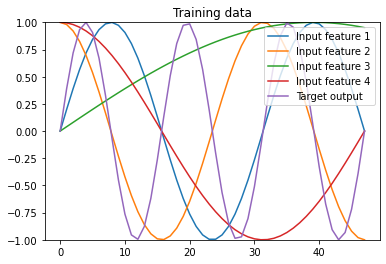

In [138]:
in_features = 4
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave
test_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N)), np.sin(np.linspace(0, 3 * np.pi*0.2, N)), np.cos(np.linspace(0, 3 * np.pi*0.5, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
test_x = torch.Tensor(test_x)
data_y = torch.Tensor(data_y)
print("data_x.size: ", str(data_x.size()))
print("data_y.size: ", str(data_y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

#Visualizing what we are shooting for
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 2")
plt.plot(data_x[0, :, 2], label="Input feature 3")
plt.plot(data_x[0, :, 3], label="Input feature 4")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

#### Creating the LTC net

In [140]:
#Building the LTC net
wiring = kncp.wirings.FullyConnected(8, out_features)  # 16 units, 8 motor neurons
ltc_cell = LTCCell(wiring, in_features)


ltc_sequence = lru.RNNSequence(
    ltc_cell,
)
learn = lru.SequenceLearner(ltc_sequence, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    gpus=0,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


alloc!


#### Investigate the fit of random weights

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 0.7815151810646057}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


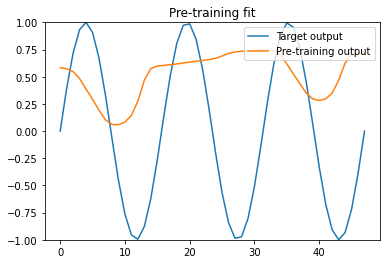

In [141]:
results = trainer.test(learn, dataloader)
y_hat = learn.predict((data_x,data_y))
#Visualizing what we are shooting for
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(y_hat[0, :, 0], label="Pre-training output")
plt.ylim((-1, 1))
plt.title("Pre-training fit")
plt.legend(loc="upper right")
plt.show()

#### Fit the dataset

In [142]:
trainer.fit(learn, dataloader)

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type        | Params
--------------------------------------
0 | model | RNNSequence | 418   
--------------------------------------
418       Trainable params
0         Non-trainable params
418       Total params
0.002     Total estimated model params size (MB)
/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the lo

Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s, loss=0.00153, v_num=25, train_loss=0.000705] 


#### Investigate the fit after the training

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 0.0007771611562930048}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


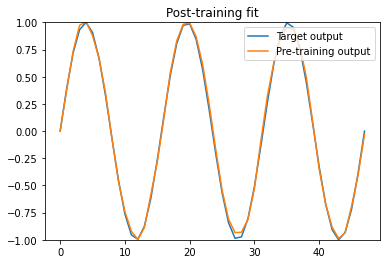

In [144]:
results = trainer.test(learn, dataloader)
y_hat = learn.predict((data_x,data_y))
#Visualizing what we are shooting for
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(y_hat[0, :, 0], label="Pre-training output")
plt.ylim((-1, 1))
plt.title("Post-training fit")
plt.legend(loc="upper right")
plt.show()

### More interesting example
Here we train a small LTC network to fit a more complex time series. 

#### Load the datasets, split into train, test and validation

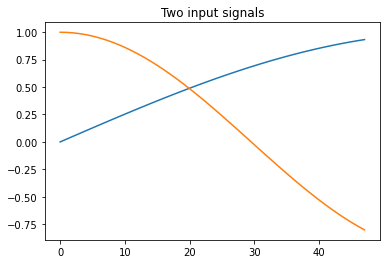

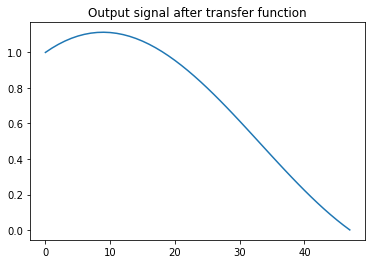

data_x.size:  torch.Size([30, 48, 2])
data_y.size:  torch.Size([30, 48, 1])


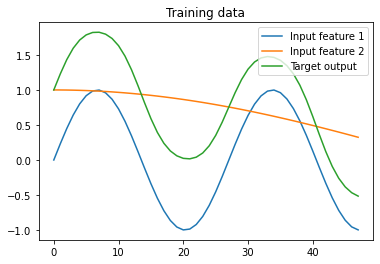

In [197]:
in_features = 2
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave

batch_size = 30
param_vect = np.random.rand(batch_size,in_features)

xs = []
ys = []
for i in range(batch_size):
    a = param_vect[i,0]*4
    b = param_vect[i,1]*2
    xs.append( [np.sin(np.linspace(0, a * np.pi, N)), np.cos(np.linspace(0, b * np.pi, N))] )
    ys.append(  np.sin(np.sin(np.linspace(0, a * np.pi, N)))+np.cos(np.linspace(0, b * np.pi, N)) )
    
data_x = np.stack(xs)
data_y = np.sin(data_x[:,0])+data_x[:,1]

i = 1

plt.plot(data_x[i,0,:])
plt.plot(data_x[i,1,:])
plt.title('Two input signals')
plt.show()
plt.plot(data_y[i,:])
plt.title('Output signal after transfer function')
plt.show()

data_x = torch.Tensor(data_x).swapaxes(1,2)
data_y = torch.Tensor(data_y).unsqueeze(1).swapaxes(1,2)
print("data_x.size: ", str(data_x.size()))
print("data_y.size: ", str(data_y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

#Visualizing what we are shooting for
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 2")
plt.plot(data_y[0, :, 0], label="Target output")
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [198]:
#Building the LTC net
wiring = kncp.wirings.FullyConnected(8, out_features)  # 16 units, 8 motor neurons
ltc_cell = LTCCell(wiring, in_features)


ltc_sequence = lru.RNNSequence(
    ltc_cell,
)
learn = lru.SequenceLearner(ltc_sequence, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    gpus=0,
)

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


alloc!


/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing:  87%|████████▋ | 26/30 [00:00<00:00, 48.47it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 1.1499462127685547}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 30/30 [00:00<00:00, 45.82it/s]


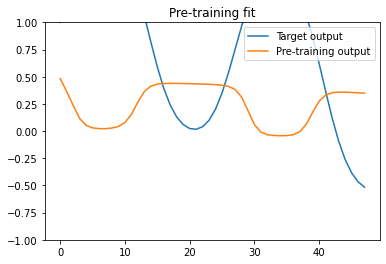

In [199]:
results = trainer.test(learn, dataloader)
y_hat = learn.predict((data_x,data_y))
#Visualizing what we are shooting for
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(y_hat[0, :, 0], label="Pre-training output")
plt.ylim((-1, 1))
plt.title("Pre-training fit")
plt.legend(loc="upper right")
plt.show()

In [200]:
trainer.fit(learn, dataloader)

/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name  | Type        | Params
--------------------------------------
0 | model | RNNSequence | 350   
--------------------------------------
350       Trainable params
0         Non-trainable params
350       Total params
0.001     Total estimated model params size (MB)
/Users/renard/miniconda3/envs/torchNCP/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the l

Epoch 399: 100%|██████████| 30/30 [00:03<00:00,  8.27it/s, loss=0.000417, v_num=26, train_loss=0.00135] 


In [254]:
in_features = 2
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave

test_size = 30
param_vect = np.random.rand(test_size,in_features)

xs = []
ys = []
for i in range(test_size):
    a = param_vect[i,0]*8
    b = param_vect[i,1]*1
    xs.append( [-np.sin(np.linspace(0, a * np.pi, N)), np.cos(np.linspace(0, b * np.pi, N))] )
    ys.append(  np.sin(np.sin(np.linspace(0, a * np.pi, N)))+np.cos(np.linspace(0, b * np.pi, N)) )
    
test_x = np.stack(xs)
test_y = np.sin(test_x[:,0])+test_x[:,1]

i = 3


test_x = torch.Tensor(test_x).swapaxes(1,2)
test_y = torch.Tensor(test_y).unsqueeze(1).swapaxes(1,2)
print("data_x.size: ", str(test_x.size()))
print("data_y.size: ", str(test_y.size()))

#Visualizing what we are shooting for
y_hat = learn.predict((test_x,test_y))
#Visualizing what we are shooting for

sample_numer = 10

def interactive_plot(i):

    plt.rcParams['figure.figsize'] = [12, 10]
    fig, axs = plt.subplots(2)

    axs[0].plot(test_x[i,:,0], label="Input feature 1")
    axs[0].plot(test_x[i,:,1], label="Input feature 2")
    axs[0].set_title('Inputs')
    axs[0].legend(loc="upper right")

    axs[1].plot(test_y[i,:], label="Target output")
    axs[1].plot(y_hat[i,:], label="Model output")
    axs[1].set_title('Output')
    axs[1].legend(loc="upper right")
    
    
interact(interactive_plot, i=(1,29));

data_x.size:  torch.Size([30, 48, 2])
data_y.size:  torch.Size([30, 48, 1])


interactive(children=(IntSlider(value=15, description='i', max=29, min=1), Output()), _dom_classes=('widget-in…